In [45]:
import pandas as pd
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from skimage import io

#Глобальная пороговая обработка

array([[206, 214, 207, ..., 204, 204, 205],
       [208, 211, 210, ..., 204, 203, 205],
       [208, 210, 210, ..., 202, 203, 203],
       ...,
       [236, 236, 236, ..., 229, 228, 228],
       [237, 236, 236, ..., 228, 228, 228],
       [236, 236, 236, ..., 228, 228, 228]], dtype=uint8)

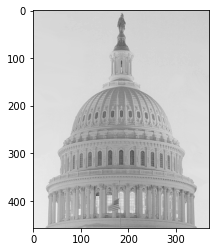

In [46]:
image_to_check = np.array(Image.open('Fig3.27(a).BMP'))
plt.imshow(image_to_check, cmap='gray', vmin=0, vmax=255)
image_to_check

In [47]:
image_to_check.shape

(457, 370)

### Гистограмма

<AxesSubplot:>

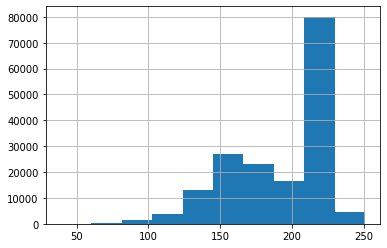

In [48]:
pd.Series(image_to_check.flat).hist()

In [49]:
t = 220
e = 0.001

# first iteration

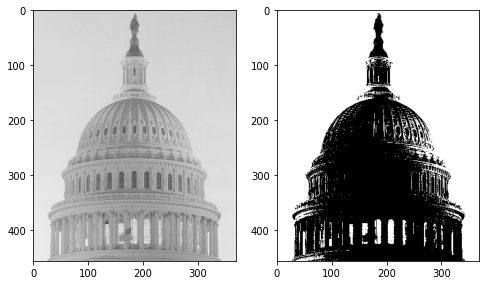

In [50]:

G1 = image_to_check[image_to_check > t]
G2 = image_to_check[image_to_check <= t]
mi1 = np.average(G1)
mi2 = np.average(G2)
t_new = (mi1 + mi2) / 2

while np.abs(t_new - t) > e:
    t = t_new
    G1 = image_to_check[image_to_check > t]
    G2 = image_to_check[image_to_check <= t]
    mi1 = np.average(G1)
    mi2 = np.average(G2)
    t_new = (mi1 + mi2) / 2

fig = plt.figure(figsize=(8, 8))
fig.add_subplot(1, 2, 1)
plt.imshow(image_to_check, cmap='gray', vmin=0, vmax=255)
fig.add_subplot(1, 2, 2)
plt.imshow(np.where(image_to_check > t_new, 1, 0), cmap='gray')
plt.show()

### Метод Отсу

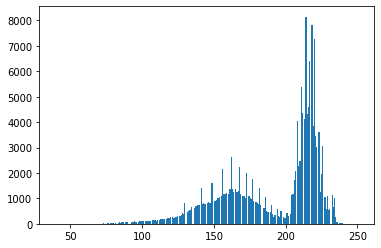

In [51]:
values = plt.hist(image_to_check.flat, bins=256)
plt.show()

In [52]:
hist = values[0] / (image_to_check.shape[0] * image_to_check.shape[1])  # from hist
img_flat = np.array(image_to_check.flat)
hist1 = np.array([0] * 256, dtype='double') # custom
for i in img_flat:
    hist1[i] += 1
hist1 /= (image_to_check.shape[0] * image_to_check.shape[1])
sum(hist1)

0.9999999999999999

In [53]:
def S(t):
    P1 = sum(hist1[:t])
    if P1 == 0:
        return 0
    P2 = 1 - P1
    M1 = sum(i * h for i, h in enumerate(hist1[:t])) / P1
    M2 = sum(i * h for i, h in enumerate(hist1[t:])) / P2
    return P1 * P2 * (M1 - M2) ** 2

S_arr = [S(i) for i in range(1, 256)]
t = S_arr.index(max(S_arr))
t

213

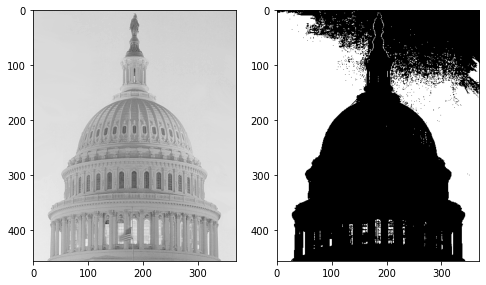

In [54]:
fig = plt.figure(figsize=(8, 8))
fig.add_subplot(1, 2, 1)
plt.imshow(image_to_check, cmap='gray', vmin=0, vmax=255)
fig.add_subplot(1, 2, 2)
plt.imshow(np.where(image_to_check > t, 1, 0), cmap='gray')
plt.show()

## Адаптивная пороговая обработка

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0, 206, 214, ..., 204, 205,   0],
       [  0, 208, 211, ..., 203, 205,   0],
       ...,
       [  0, 237, 236, ..., 228, 228,   0],
       [  0, 236, 236, ..., 228, 228,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

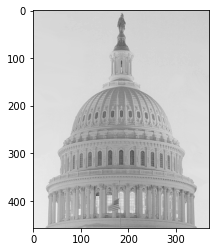

In [55]:
plt.imshow(im,cmap='gray', vmin=0, vmax=255)
image = np.pad(im, 1)
image

In [56]:
image_res = np.copy(image)


def calc_t(m, n, K=1, a=1 / 3):
    temp_arr = [image[m + i][n + j] for i in range(-K, K + 1) for j in range(-K, K + 1)]
    f_max = max(temp_arr)
    f_min = min(temp_arr)
    P_ = 1 / (2 * K + 1) ** 2 * sum(temp_arr)
    d_f_max = np.abs(f_max - P_)
    d_f_min = np.abs(f_min - P_)

    if d_f_max > d_f_min:
        return a * (2 / 3 * f_min + 1 / 3 * P_), K
    if d_f_max < d_f_min:
        return a * (1 / 3 * f_min + 2 / 3 * P_), K
    if d_f_max == d_f_min and f_max != f_min:
        return calc_t(m, n, K=K + 1)
    return a * P_, K

In [57]:
def calc_P_l(m, n, K):
    return 1 / (2 * K + 1) ** 2 * sum(image[m + i][n + j] for i in range(-K, K + 1) for j in range(-K, K + 1))

In [58]:
for m in range(1, im.shape[0] + 1):
    for n in range(1, im.shape[1]):
        f = False
        t, K = calc_t(m, n)

        temp_arr = [(i, j) for i in range(-1, 2) for j in range(-1, 2) if j != 0 or i != 0]
        for l in temp_arr:
            if np.abs(calc_P_l(m + l[0], n + l[1], K) - image[m][n]) <= t:
                image_res[m][n] = 0
                f = True; break
        if f:
            continue
        image_res[m][n] = 1

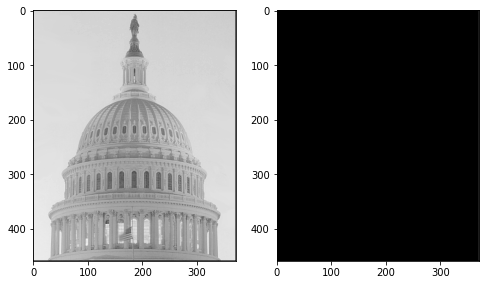

In [59]:
fig = plt.figure(figsize=(8, 8))
fig.add_subplot(1, 2, 1)
plt.imshow(image, cmap='gray', vmin=0, vmax=255)
fig.add_subplot(1, 2, 2)
plt.imshow(image_res, cmap='gray', vmin=0, vmax=255)
plt.show()

In [60]:
calc_t(100, 12)

(72.66666666666666, 1)

In [61]:
np.abs(calc_P_l(100 + 1, 25 + 1, K) - image[m][n])

10.0

# Нелинейные фильтры

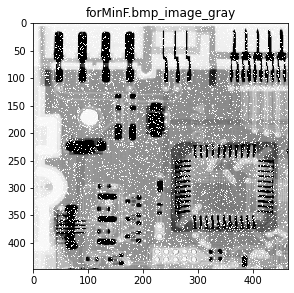

In [62]:
def deal_image(path):
    im=io.imread(path)
    io.imshow(im)
    plt.title(path+'_image_gray')
    plt.show()
    im_copy_med=io.imread(path)
    im_copy_max=io.imread(path)
    im_copy_min=io.imread(path)
    #io.imshow(im)
    for i in range(0,im.shape[0]):
        for j in range(0,im.shape[1]):
            im_copy_med[i][j]=im[i][j]
            im_copy_max[i][j]=im[i][j]
            im_copy_min[i][j]=im[i][j]
         # Определить фильтр
    return im,im_copy_med,im_copy_max,im_copy_min
im,im_copy_med,im_copy_max,im_copy_min=deal_image('forMinF.bmp')


### Медианный фильтр

In [63]:
def m_filter(x, y, step):
    sum_s=[]
    for k in range(-int(step/2),int(step/2)+1):
        for m in range(-int(step/2),int(step/2)+1):
            sum_s.append(im[x+k][y+m])
    sum_s.sort()
    return sum_s[(int(step*step/2)+1)]

# Фильтр Максимума

In [64]:
def max_filter(x,y,step):
    sum_s=[]
    for k in range(-int(step/2),int(step/2)+1):
        for m in range(-int(step/2),int(step/2)+1):
            sum_s.append(im[x+k][y+m])
    sum_s.sort()
    return max(sum_s)

# Фильтр Минимума

In [65]:
def min_filter(x,y,step):
    sum_s=[]
    for k in range(-int(step/2),int(step/2)+1):
        for m in range(-int(step/2),int(step/2)+1):
            sum_s.append(im[x+k][y+m])
    sum_s.sort()
    return min(sum_s)

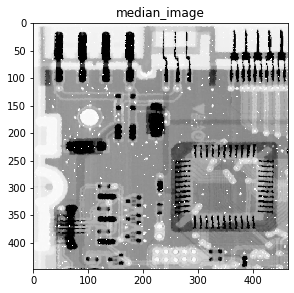

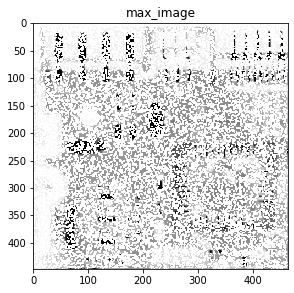

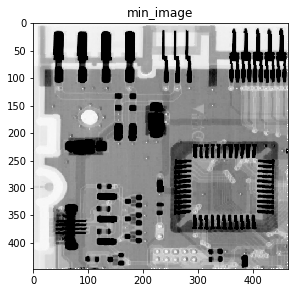

In [66]:

def test(Step):
    for i in range(int(Step/2),im.shape[0]-int(Step/2)):
        for j in range(int(Step/2),im.shape[1]-int(Step/2)):
            im_copy_med[i][j] = m_filter(i, j, Step)
            im_copy_max[i][j]=max_filter(i,j,Step)
            im_copy_min[i][j]=min_filter(i,j,Step)

    io.imshow(im_copy_med)
    plt.title('median_image')
    plt.show()
    #io.imsave(str(Step) + 'med.jpg', im_copy_med)
    io.imshow(im_copy_max)
    plt.title('max_image')
    plt.show()
    #io.imsave(str(Step) + 'max.jpg', im_copy_max)
    io.imshow(im_copy_min)
    plt.title('min_image')
    io.imsave(str(Step) + 'min.jpg', im_copy_min)
    plt.show()


test(3)
